# Прогнозирование температуры звезды
От обсерватории «Небо на ладони» поступила задача: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

Необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

## Загрузка данных

Импортируем библиотеки:

In [ ]:
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.regressor import NeuralNetRegressor
from skorch.dataset import ValidSplit
import torch
from torch import nn
import random


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

Считаем датасет и сохраним в переменную:

In [ ]:
try:
    df = pd.read_csv('/content/6_class.csv')
except Exception:    
    df = pd.read_csv('6_class.csv')

Выведем на экран первые, последние и случайные пять строк таблицы, а также общую информацию. Создадим для этого собственную функцию и применим ее к датасету:

In [ ]:
def total_view(df, n_rows=5, seed=None):
    '''Возвращает первые, случайные и последние строки таблицы (по умолчанию по 5 строк)'''
    return pd.concat([df.head(n_rows),
                      df.sample(n_rows,random_state=seed),
                      df.tail(n_rows)
                     ])

display(total_view(df), df.describe().T)
df.info()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
109,109,33421,352000.000000,67.0000,-5.79,4,Blue
71,71,3607,0.022000,0.3800,10.12,1,Red
37,37,6380,1.350000,0.9800,2.93,3,yellow-white
74,74,3550,0.004000,0.2910,10.89,1,Red
108,108,24345,142000.000000,57.0000,-6.24,4,Blue


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,240.0,119.500000,69.426220,0.00000,59.750000,119.5000,179.2500,239.00
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


В датасете 240 строк и 7 объектов. Тип данных в колонках `float64`, `int64` и `object` - соответствует содержащимся в них типам данных.
Согласно документации, к признакам относятся следующие колонки:
* `Absolute magnitude(Mv)` - абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды;
* `Luminosity(L/Lo)` - светимость звезды относительно Солнца;
* `Radius(R/Ro)` - радиус звезды относительно радиуса Солнца;
* `Star color` - звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
* `Star type` - тип звезды;
* `Unnamed: 0` - порядковый номер.


Целевой признак:
* `Temperature (K)` - температура звезды в Кельвинах.

**Выводы:**
- в каждой строке датасета содержатся характеристики звезды, к целевому признаку относится колонка `Temperature (K)`;
- пропущенные значения отсутствуют. Минимальные и максимальные значения характеристик в пределах нормы;
- требуется проверка данных на дубликаты и неявные дубликаты.

## Предобработка и анализ данных

###  Предобработка

Проверим уникальные значения в колонках с категориальными данными:

In [ ]:
df['Star color'] = df['Star color'].str.lower()
for column in ['Star type', 'Star color']:
    print(f'{column}: {df[column].unique()}')

Star type: [0 1 2 3 4 5]
Star color: ['red' 'blue white' 'white' 'yellowish white' 'pale yellow orange' 'blue'
 'blue-white' 'whitish' 'yellow-white' 'orange' 'white-yellow' 'blue '
 'yellowish' 'orange-red' 'blue white ']


Среди цветов звед встречаются неявные дубликаты. Всего выделяют 7 основных классов звезд. Их цвета: голубой, бело-голубой, белый, желто-белый, желтый, оранжевый и красный. Заменим значения:

In [ ]:
corr_dict = {'blue white': 'blue-white',
             'blue white ': 'blue-white',
             'blue ': 'blue',
             'yellowish white': 'yellow-white',
             'yellowish': 'yellow',
             'white-yellow': 'yellow-white',
             'whitish': 'white',
             'pale yellow orange': 'orange',
             'orange-red': 'red'
              }
df['Star color'] = df['Star color'].map(lambda x: corr_dict.get(x, x))
df['Star color'].unique()

array(['red', 'blue-white', 'white', 'yellow-white', 'orange', 'blue',
       'yellow'], dtype=object)

Удалим колонку с порядковым номером, т.к. она не понадобится:

In [ ]:
df = df.drop('Unnamed: 0', axis=1)

Проверим данные на наличие дубликатов:

In [ ]:
df.duplicated().sum()

0

### Анализ

Посмотрим на распределение количественных признаков:

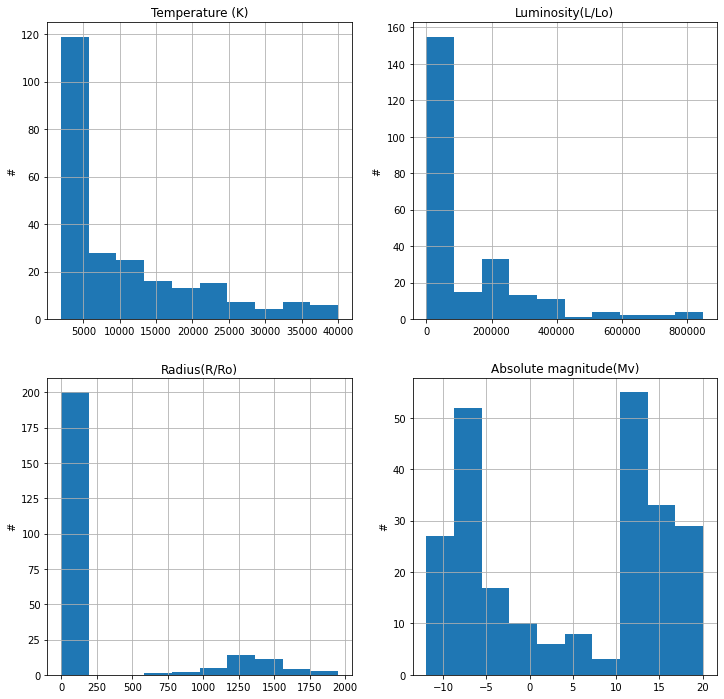

In [ ]:
column_list = ['Temperature (K)',
               'Luminosity(L/Lo)',
               'Radius(R/Ro)',
               'Absolute magnitude(Mv)']
cnt = 1
plt.figure(figsize=(12, 12))
for column in column_list:
    plt.subplot(2, 2, cnt)
    df[column].hist(bins=10)
    plt.ylabel('#')
    plt.title(column)
    cnt += 1
None

По графикам видно, что ни одна величина не имеет нормального распределения. Вероятно, это произошло из-за нерепрезентативности выборки или существующей закономерности встречающихся видов звезд и их характеристик. Температура, светимость и радиус на графике имеют высокий пик слева и длинный хвость справа. Абсолютная магнитуда имеет два максимума.

Построим матрицу корреляции количественных признаков:

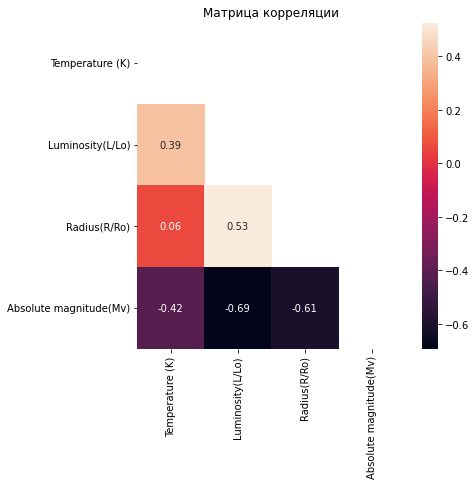

In [ ]:
plt.figure(figsize=(6,6))
plt.title('Матрица корреляции')
matrix = np.triu(df[column_list].corr())
sns.heatmap(df[column_list].corr(), annot=True, fmt='.2f', mask=matrix)
None

- самая сильная и обратная корреляция у целевой переменной с абсолютной звездной величиной (блеском звезды). коэффициент Пирсона составляет -0.42, это значит, что чем выше эта величина, тем ниже температура звезды;
- между светимостью звезды и ее температурой прямая взаимосвязь, коэффициент Пирсона составляет 0.39;
- между радиусом звезды относительно Солнца и ее температурой линейная взаимосвязь почти отсутствует (коэффициент 0.06), возможно, существует нелинейная взаимосвязь.

Посмотрим на точечные диаграммы количественных величин:

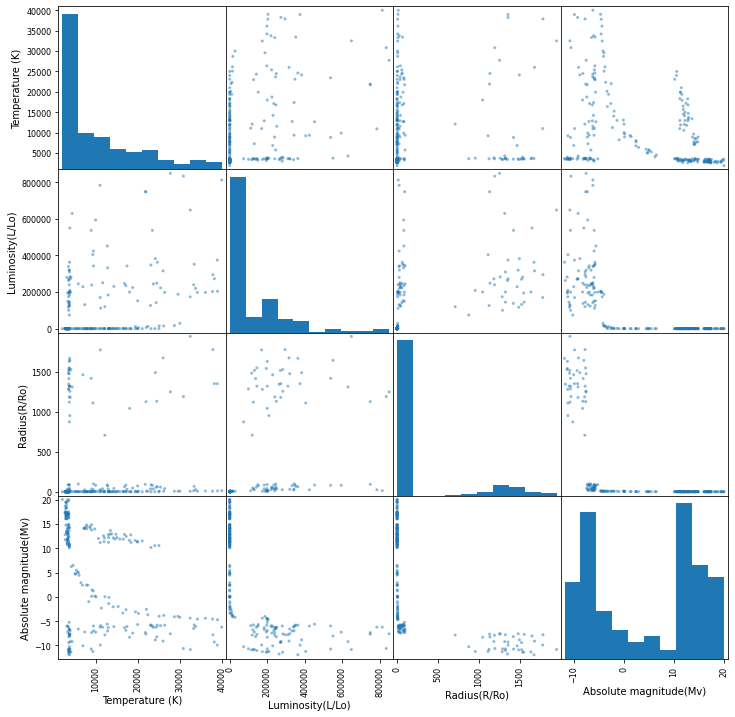

In [ ]:
pd.plotting.scatter_matrix(df[['Temperature (K)',
                               'Luminosity(L/Lo)',
                               'Radius(R/Ro)',
                               'Absolute magnitude(Mv)']], figsize=(12, 12))
None

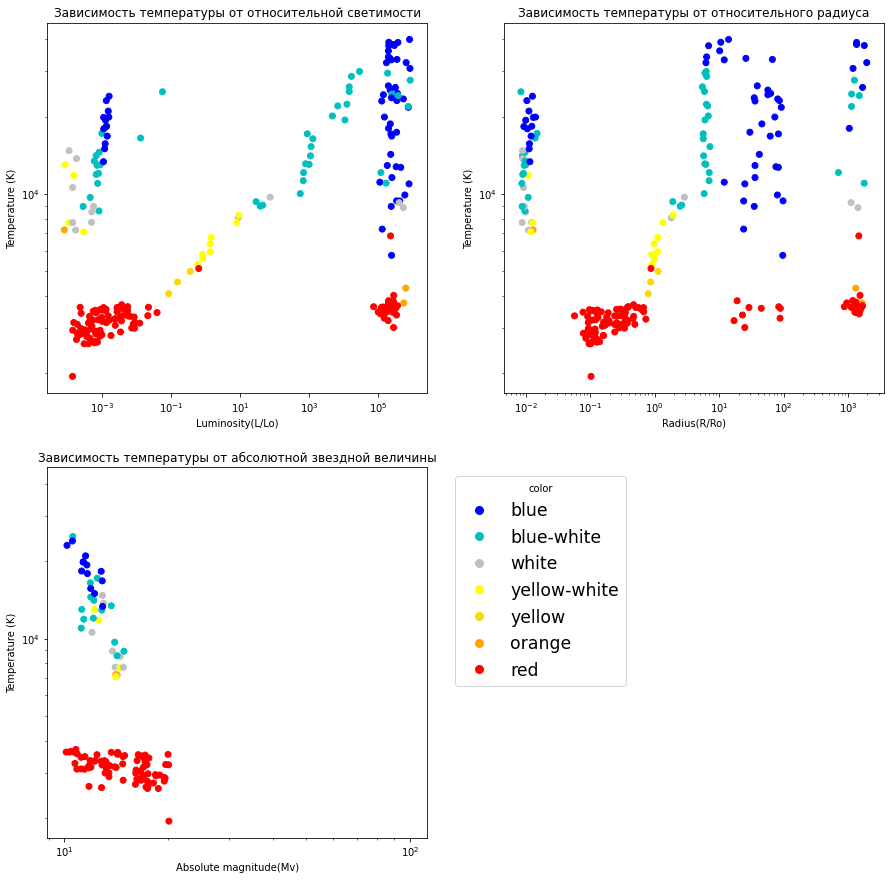

In [ ]:
plt.figure(figsize=(15, 15))
cnt = 1
colors = {'blue':'b',
          'blue-white': 'c',
          'white': 'silver',
          'yellow-white': 'yellow',
          'yellow': 'gold',
          'orange':'orange',
          'red': 'r'}

y = df.loc[:, 'Temperature (K)'].values
for column in ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']:
    plt.subplot(2, 2, cnt)
    x = df.loc[:, column].values
    plt.scatter(x, y, c=df['Star color'].map(colors))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(column)
    plt.ylabel('Temperature (K)')
    if cnt == 1:
        plt.title('Зависимость температуры от относительной светимости')
    if cnt == 2:
        plt.title('Зависимость температуры от относительного радиуса')
    if cnt == 3:
        plt.title('Зависимость температуры от абсолютной звездной величины')
# добавление легенды
        handles = [lines.Line2D([0],
                                [0],
                                marker='o',
                                color='w',
                                markerfacecolor=v,
                                label=k,
                                markersize=10) for k, v in colors.items()]
        plt.legend(title='color',
                   handles=handles,
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left',
                   fontsize='xx-large')
    cnt += 1
None

На обычных точечных диаграммах не видно какой-то определенной взаимосвязи признаков с целевой переменной. На диаграммах с логарифмической шкалой точки начинают выстраиваться в определенную сложную последовательность (в частности, зависимость температуры от относительной светимости по виду напоминает перевернутую диаграмму Герцшпрунга Рассела).

Посмотрим на распределение категориальных признаков:

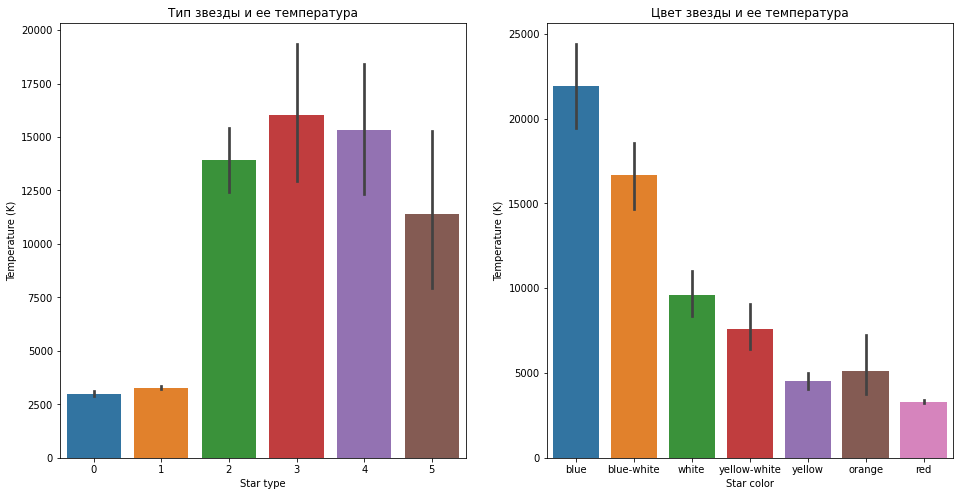

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.2)
cnt = 1
for column in ['Star type', 'Star color']:
    plt.subplot(1, 2, cnt)
    if cnt == 1:
        sns.barplot(y='Temperature (K)', x=column, data=df)
        plt.title('Тип звезды и ее температура')
    if cnt == 2:
        sns.barplot(y='Temperature (K)', x=column, data=df, order=['blue',
                                                                   'blue-white',
                                                                   'white',
                                                                   'yellow-white',
                                                                   'yellow',
                                                                   'orange',
                                                                   'red'])
        plt.title('Цвет звезды и ее температура')
    cnt += 1

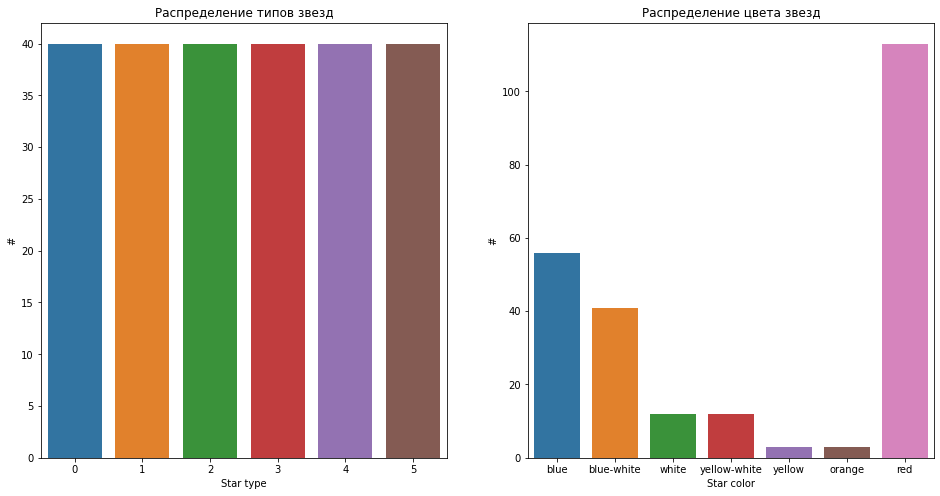

In [ ]:
pivot_color = (df.pivot_table(index='Star color',
                             values='Star type',
                             aggfunc='count')
               .reset_index()
               .rename(columns={"Star type": "#"}))

pivot_type = (df.pivot_table(index='Star type',
                            values='Star color',
                            aggfunc='count')
              .reset_index()
              .rename(columns={"Star color": "#"}))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.barplot(data=pivot_type, x='Star type', y='#')
plt.title('Распределение типов звезд')

plt.subplot(1, 2, 2)
sns.barplot(data=pivot_color, x='Star color', y='#', order=['blue',
                                                            'blue-white',
                                                            'white',
                                                            'yellow-white',
                                                            'yellow',
                                                            'orange',
                                                            'red'])
plt.title('Распределение цвета звезд')
None

- типы звезд распределены равномерно, каждый цвет встречается в выборке 40 раз. Самая высокая температура у звезд 2-5 типа, самая низкая у 0 и 1;
- температура звезды зависит от ее цвета - чем холоднее оттенок, тем выше температура. Из данного наблюдения немного выбиваются звезды оранжевого и желтого цвета, т.к. температура желтых звезд оказалась ниже, чем тепература оранжевых. Скорее всего температуру этих звезд определили неточно, а самих звезд такого цвета в выборке мало - по 3;
- больше всего в выборке звезд красного цвета - примерно половина от всего количества, на втором и третьем месту по количеству голубые и бело-голубые звезды.

### Подготовка выборок

Разделим датасет на обучающую и тестовую выборку:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Temperature (K)', axis=1),
                                                    df['Temperature (K)'],
                                                    test_size=0.2,
                                                    random_state=42)

print(' X_train:',X_train.shape, '\n',
      'y_train:', y_train.shape, '\n',
      'X_test:', X_test.shape, '\n',
      'y_test:', y_test.shape)

 X_train: (192, 5) 
 y_train: (192,) 
 X_test: (48, 5) 
 y_test: (48,)


Закодируем категориальные признаки:

In [ ]:
cat_features = ['Star color', 'Star type']
ohe = OneHotEncoder()
ohe.fit(X_train[cat_features])

train_ohe = ohe.transform(X_train[cat_features]).toarray()

test_ohe = ohe.transform(X_test[cat_features]).toarray()

cats = ohe.get_feature_names()

X_train = pd.concat([pd.DataFrame(train_ohe, columns=cats),
                     X_train.drop(['Star color', 'Star type'], axis=1).reset_index(drop=True)],axis=1)

X_test = pd.concat([pd.DataFrame(test_ohe, columns=cats),
                    X_test.drop(['Star color', 'Star type'], axis=1).reset_index(drop=True)],axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Приведем числовые данные к одному порядку:

In [ ]:
numeric = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
display(total_view(X_train), X_test.head())

,x0_blue,x0_blue-white,x0_orange,x0_red,x0_white,x0_yellow,x0_yellow-white,x1_0,x1_1,x1_2,x1_3,x1_4,x1_5,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.581290,-0.433580,0.922677
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.581290,-0.433984,1.105516
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.581290,-0.434074,0.623397
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.581290,-0.433858,1.222919
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.581290,-0.434078,0.523316
184,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.581290,-0.434082,0.561809
170,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.036694,1.964955,-1.341648
182,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.581290,-0.433901,1.462535
143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.871862,-0.363121,-1.059690
98,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.495037,-0.422094,-0.839320


,x0_blue,x0_blue-white,x0_orange,x0_red,x0_white,x0_yellow,x0_yellow-white,x1_0,x1_1,x1_2,x1_3,x1_4,x1_5,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv)
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.581290,-0.434071,0.687872
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.581290,-0.433842,1.200785
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.581288,-0.431808,0.003667
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.512572,-0.298227,-1.013499
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.084939,-0.409764,-1.025047


In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)

**Выводы:**
- выбросы и пропуски в данных отсутствуют. Все количественные значения в пределах нормы, неявные дубликаты среди категориальных данных устранены, полные дубликаты отсутствуют;
- выборка не сбалансирована относительно цвета звезды, половина объектов это звезды красного цвета, желтые и оранжевые звезды представлены в незначительном количестве. Из-за этого количественные характеристики, напрямую коррелирующие с цветом звезды, распределены не равномерно;
- прослеживается сложная взаимосвязь между температурой звезды, цветом и различными количественными характеристиками;
- колонки `Star color` и `Star type` закодированы с помощью OHE, проведено масштабирование числовых признаков, данные разделены на выборки следующим образом: обучающая - 80%, тестовая - 20%.

## Построение базовой нейронной сети

Построим модель с одним скрытым слоем:

In [ ]:
class Net(nn.Module):
    
    def __init__(self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super().__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0, std=0.57)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

Напишем функцию обучения нейронной сети:

In [ ]:
def training(net,
             num_epochs,
             batch_size,
             loss,
             optimizer,
             X_train,
             y_train,
             X_test,
             y_test
             ):
    """Trains net and returns best predictions"""
    
    optimizer = optimizer
    num_batches = ceil(len(X_train)/batch_size)
    best_rmse = 99999
    best_epoch = None
    best_preds = None
    

    for epoch in range(1, num_epochs+1):
        net.train()
        order = np.random.permutation(len(X_train))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net.forward(X_batch).flatten(start_dim=-2)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
            
        if epoch % 100 == 0 or epoch == num_epochs :
            with torch.no_grad():
                net.eval()
                test_preds = net.forward(X_test)
                rmse = mean_squared_error(y_test, test_preds.detach().numpy(), squared=False)
                print(f'{epoch}:  {rmse}')
        
            if rmse < best_rmse:
                best_rmse = rmse
                best_epoch = epoch
                best_preds = test_preds

    print(f'RMSE: {round(best_rmse)}',
          f'epoch: {best_epoch}',
          sep='\n')
    
    return best_preds

In [ ]:
num_epochs = 60000
n_in_neurons = 16
n_hidden_neurons = 7
n_out_neurons = 1
batch_size = 100


torch.manual_seed(0)
np.random.seed(0)

net = Net(n_in_neurons, n_hidden_neurons, n_out_neurons)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

preds = training(net,
                 num_epochs,
                 batch_size,
                 loss,
                 optimizer,
                 X_train,
                 y_train,
                 X_test,
                 y_test
                )

100:  15244.506602843956
200:  15206.01421735653
300:  15133.04427345164
400:  15033.943582755648
500:  14912.092649732545
600:  14769.991946311628
700:  14609.73040642608
800:  14433.858904390148
900:  14244.417931214817
1000:  14043.08394933211
1100:  13832.087482099649
1200:  13612.607948457779
1300:  13386.635456063881
1400:  13155.280643105436
1500:  12920.06746699259
1600:  12681.993967529754
1700:  12442.266037674734
1800:  12202.193161344841
1900:  11962.786913141254
2000:  11724.704778526931
2100:  11488.584971984736
2200:  11255.686430285343
2300:  11026.626638759395
2400:  10801.469459950877
2500:  10580.63419556313
2600:  10364.55852887541
2700:  10153.814099981579
2800:  9949.054434955682
2900:  9750.760134797867
3000:  9559.716804591202
3100:  9376.180857476855
3200:  9200.522519445174
3300:  9032.918167595364
3400:  8873.794463062191
3500:  8722.860582783844
3600:  8579.64347529302
3700:  8443.990343717518
3800:  8315.563396866139
3900:  8193.848366737298
4000:  8078.653

Модель достигла минимума за 53200 эпох. RMSE составила 4854 Кельвинов.

Построим модель с двумя скрытыми слоями:

In [ ]:
class Net2(nn.Module):
    
    def __init__(self,
                 n_in_neurons,
                 n_hidden_neurons_1,
                 n_hidden_neurons_2,
                 n_out_neurons,
                 activation,
                 dropout):
        super().__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = activation
        self.dp = nn.Dropout(dropout)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        nn.init.normal_(self.fc1.bias, mean=0, std=0.57)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.normal_(self.fc1.bias, mean=0, std=0.43)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [ ]:
num_epochs = 30000
n_in_neurons = 16
n_hidden_neurons_1 = 7
n_hidden_neurons_2 = 3
n_out_neurons = 1
batch_size = 100

torch.manual_seed(0)
np.random.seed(0)

net = Net2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, nn.ELU(), 0)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

preds = training(net,
                 num_epochs,
                 batch_size,
                 loss,
                 optimizer,
                 X_train,
                 y_train,
                 X_test,
                 y_test
                )

100:  15237.978748931311
200:  15099.042752094925
300:  14714.945362784934
400:  14031.089730475162
500:  13074.66683729578
600:  11953.739373900977
700:  10825.109859936727
800:  9825.430788083047
900:  8987.701719059256
1000:  8296.64756464206
1100:  7738.712475507893
1200:  7237.169481212667
1300:  6753.255123612597
1400:  6297.09011014844
1500:  5927.978406926951
1600:  5648.569517174227
1700:  5452.117249235933
1800:  5313.50992913802
1900:  5217.367461732994
2000:  5151.681697748567
2100:  5107.042330448528
2200:  5078.899176695063
2300:  5061.407352726855
2400:  5050.23481514793
2500:  5043.795515895268
2600:  5038.261432170049
2700:  5031.459856358075
2800:  5024.87948461132
2900:  5020.930328608418
3000:  5012.555411184222
3100:  5006.448059030505
3200:  5000.3832877137
3300:  4995.586065045081
3400:  4989.187239762916
3500:  4980.8458125354855
3600:  4975.227197712761
3700:  4968.287208363037
3800:  4961.233056894078
3900:  4953.581311519773
4000:  4947.126265469058
4100:  49

Модель показала себя лучше и достигла минимума за 25800 эпох. Метрика RMSE составила 4496 Кельвинов.

Построим график с фактическими и предсказанными значениями второй модели:

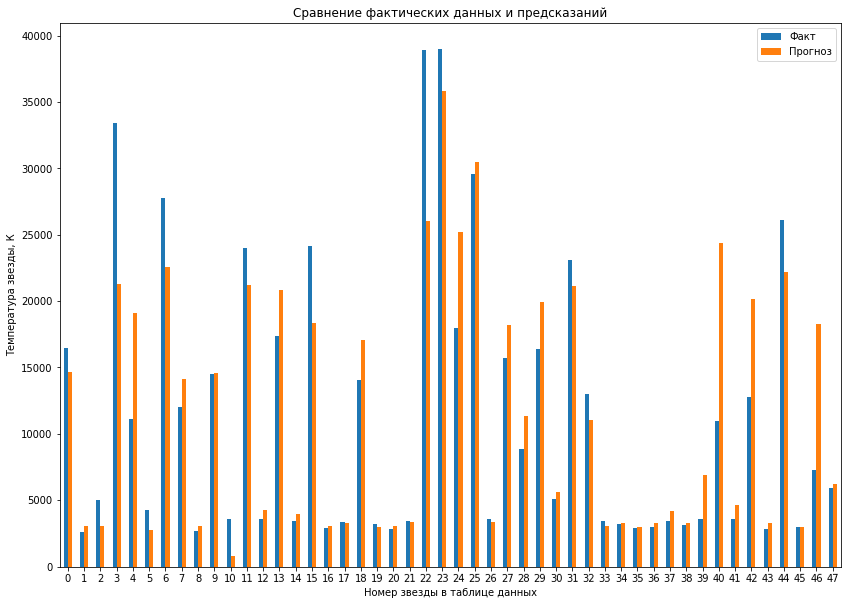

In [ ]:
def pred_test_comparision(y_pred, y_test):
    d = {'Факт': y_test.reset_index(drop=True),
         'Прогноз': np.round(y_pred.detach().numpy().flatten())}
    data = pd.DataFrame(data=d)

    data.plot(kind='bar',
              figsize=(14, 10),
              title='Сравнение фактических данных и предсказаний',
              xlabel='Номер звезды в таблице данных',
              ylabel='Температура звезды, К',
              rot=1)

pred_test_comparision(preds, y_test)

На графике видно, что модель сильнее ошибалась с предсказанием температуры звезд, у которых она выше, чем у большинства. В ходе анализа данных мы выяснили, что самая низкая температура у звед красного, оранжевого и желтого цвета. Учитывая, что половину всех представленных в выборке звезд составляют красные зведы, можно сделать вывод, что модель хорошо обучилась предсказывать температуру для красных звезд и плохо для остальных, т.к. выборка не сбалансирована по цвету звезды.

## Улучшение нейронной сети

Подберем параметры - dropout, размер батча и скорость обучения:

In [ ]:
def rmse(y_true, y_pred):
    '''Returns calculated RMSE'''
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse)

In [ ]:
n_in_neurons = 16
n_hidden_neurons_1 = 7
n_hidden_neurons_2 = 3
n_out_neurons = 1

torch.manual_seed(0)
np.random.seed(0)

net = Net2(16, 7, 3, 1, nn.ELU(), 0)

skorch_regressor = NeuralNetRegressor(
                                      module=net, 
                                      device='cpu',  
                                      verbose=10,
                                      batch_size=100,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=20000, 
                                      lr=0.003,
                                      train_split=ValidSplit(cv=5),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                                                 ('val_rmse',
                                                  EpochScoring(scoring=rmse_scorer,
                                                               lower_is_better=True,
                                                               name='RMSE')),
                                                 ('estoper',
                                                  EarlyStopping(lower_is_better=True,
                                                                           monitor='RMSE',
                                                                           patience=500))
                                                ]
                                     )

params = {
          'module__n_in_neurons': [X_train.shape[1]],
          'module__n_hidden_neurons_1': [7],
          'module__n_hidden_neurons_2': [3],
          'module__n_out_neurons': [1],
          'module__dropout': [0, 0.1],
          #'module__activation': [nn.LeakyReLU(), nn.Tanh(), nn.ReLU(), nn.ELU()],
          'module__activation': [nn.ELU()],
          'lr': [1e-3, 4e-3],
          'batch_size':[50, 70]
         }

grid = GridSearchCV(skorch_regressor,
                    params,
                    cv=3,
                    scoring="neg_root_mean_squared_error",
                    verbose=False,
                    n_jobs=-1
                   ) 
grid.fit(X_train, y_train.reshape(-1,1))

Streaming output truncated to the last 5000 lines.
   1947  5526.0552  13790860.0558  30537284.0000  0.0098
   1948  5525.9966  13788979.8407  30536628.0000  0.0109
   1949  5525.9380  13787105.8342  30535996.0000  0.0113
   1950  5525.8799  13785236.3519  30535346.0000  0.0104
   1951  5525.8218  13783372.4357  30534712.0000  0.0082
   1952  5525.7651  13781512.0725  30534078.0000  0.0124
   1953  5525.7080  13779660.2496  30533448.0000  0.0109
   1954  5525.6523  13777811.7388  30532832.0000  0.0122
   1955  5525.5957  13775969.6113  30532208.0000  0.0101
   1956  5525.5410  13774132.1362  30531604.0000  0.0133
   1957  5525.4863  13772300.9242  30531004.0000  0.0114
   1958  5525.4321  13770474.9116  30530402.0000  0.0120
   1959  5525.3784  13768650.8143  30529808.0000  0.0090
   1960  5525.3252  13766836.5357  30529218.0000  0.0150
   1961  5525.2729  13765022.6054  30528636.0000  0.0109
   1962  5525.2197  13763218.4569  30528056.0000  0.0115
   1963  5525.1675  13761416.6070  30

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=Net2(
    (fc1): Linear(in_features=16, out_features=7, bias=True)
    (act1): ELU(alpha=1.0)
    (dp): Dropout(p=0, inplace=False)
    (fc2): Linear(in_features=7, out_features=3, bias=True)
    (act2): ReLU()
    (fc3): Linear(in_features=3, out_features=1, bias=True)
  ),
),
             n_jobs=-1,
             param_grid={'batch_size': [50, 70], 'lr': [0.001, 0.004],
                         'module__activation': [ELU(alpha=1.0)],
                         'module__dropout': [0, 0.1],
                         'module__n_hidden_neurons_1': [7],
                         'module__n_hidden_neurons_2': [3],
                         'module__n_in_neurons': [16],
                         'module__n_out_neurons': [1]},
             scoring='neg_root_mean_squared_error', verbose=False)

In [ ]:
preds = grid.predict(X_test)
rmse = mean_squared_error(preds, y_test, squared=False)
print(f'параметры: {grid.best_params_}',
      f'RMSE valid: {abs(grid.best_score_)}',
      f'RMSE test: {rmse}',
      sep='\n')

параметры: {'batch_size': 50, 'lr': 0.004, 'module__activation': ELU(alpha=1.0), 'module__dropout': 0, 'module__n_hidden_neurons_1': 7, 'module__n_hidden_neurons_2': 3, 'module__n_in_neurons': 16, 'module__n_out_neurons': 1}
RMSE valid: 4594.395833333333
RMSE test: 4464.783239052934


Наименьшая метрика RMSE на кросс-валидации составила 4594 Кельвина, на тесте 4465 Кельвинов с dropout 0, размером батча 50 и скоростью обучения 0.004.

Построим график с фактическими и предсказанными значениями модели:

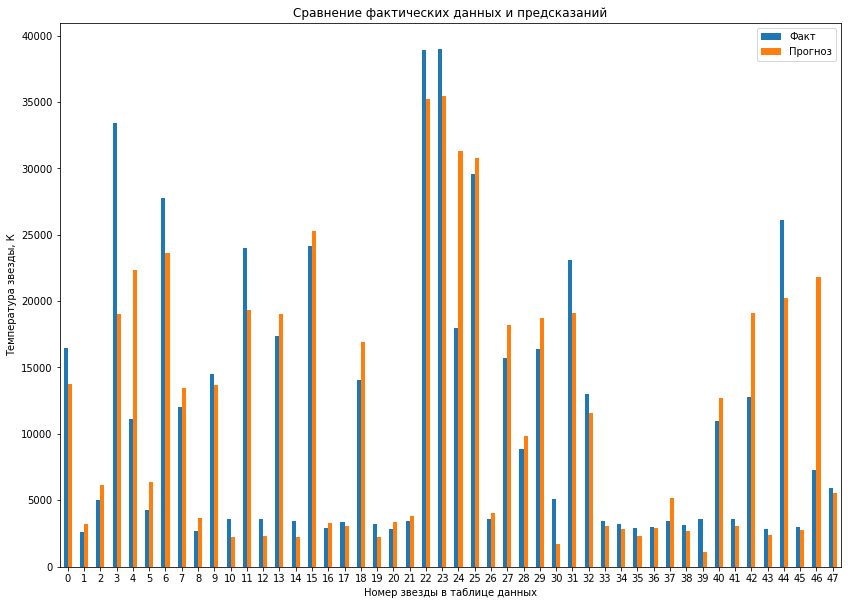

In [29]:
best_preds = torch.FloatTensor(preds)
pred_test_comparision(best_preds, y_test)

Здесь наблюдается аналогичная с предыдущим графиком картина. Визуально предсказания остались такими же, тк метрика RMSE уменьшилась незначительно относительно высоких температур и количества звезд с такой температурой.

Сравним результаты исследования в таблице:

In [31]:
d = {'RMSE': [4854, 4496, 4465],
    'epoch': [53200, 25800, '-'],
    'batch size': [100, 100, 50],
    'dropout': [0, 0, 0],
    'learning rate': [0.003, 0.003, 0.004]}

pd.DataFrame(data=d, index=['1 hidden layer NN',
                            '2 hidden layers NN',
                            '2 hidden layers NN with parameters'])

,RMSE,epoch,batch size,dropout,learning rate
1 hidden layer NN,4854,53200,100,0,0.003
2 hidden layers NN,4496,25800,100,0,0.003
2 hidden layers NN with parameters,4465,-,50,0,0.004


## Выводы

- модель с одним скрытым слоем показала себя хуже всего. Наилучшее достигнутое значение RMSE составило 4854 Кельвинов за 53200 эпох;
- модель с двумя скрытыми слоями показала себя лучше: RMSE составила 4496 Кельвинов, для этого потребовалось 25800 эпох;
- с помощью перебора значений dropout и размера батча удалось незначительно понизить метрику модели с двумя скрытыми слоями до 4465 Кельвинов. Параметры финальной модели: размер батча 50, dropout 0 и learning rate 0.004.